# INTEGRATE Synthetic Case Study example
An example using inverting data obtained from synthetic reference model


In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # # # #%load_ext autoreload
    # # # # # # # # # #%autoreload 2
    pass

import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
hardcopy=True

Notebook detected. Parallel processing is OK


# Create The reference model and data

In [2]:
# Create reference model

# select the type of referenc model
case = 'wedge'
case = '3layer'

z_max = 60
rho = [120,10,120]
if case.lower() == 'wedge':
    # Make Wedge MODEL
    M_ref, x_ref, z_ref = ig.synthetic_case(case='Wedge', wedge_angle=10, z_max=z_max, dz=.5, x_max=100, dx=.1, z1=15, rho = rho)
elif case.lower() == '3layer':
    # Make 3 layer MODEL
    M_ref, x_ref, z_ref = ig.synthetic_case(case='3layer', dx=1, rho1_1 = rho[0], rho1_2 = rho[1], x_max = 100, x_range = 10)

# Create reference data
f_data_h5 = '%s_%d' % (case,z_max)    
thickness = np.diff(z_ref)
file_gex = 'TX07_20231016_2x4_RC20-33.gex'
D_ref = ig.forward_gaaem(C=1./M_ref, thickness=thickness, file_gex=file_gex)

# Initialize random number generator to sample from noise model!
rng = np.random.default_rng()
d_std = 0.01
d_std_base = 1e-12
D_std = d_std * D_ref + d_std_base
D_noise = rng.normal(0, D_std, D_ref.shape)
D_obs = D_ref + D_noise

# Write to hdf5 file
f_data_h5 = ig.write_data_gaussian(D_obs, D_std = D_std, f_data_h5 = f_data_h5, id=1, showInfo=1)
#check_data(f_data_h5)

gatdaem1d: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.60it/s]

100 40
Removing group 3layer_60:D1 
Adding group 3layer_60:D1 


plot_data: Found data set D1
plot_data: Using data set D1


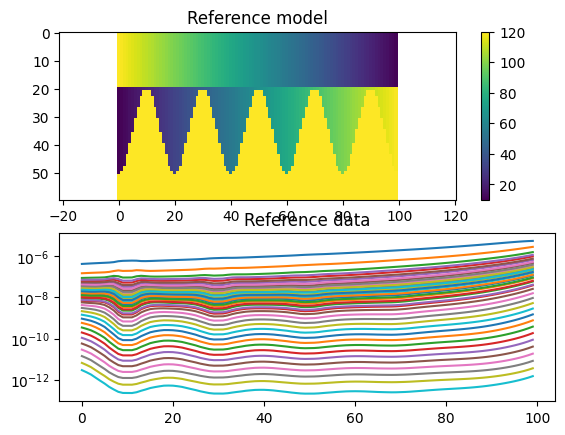

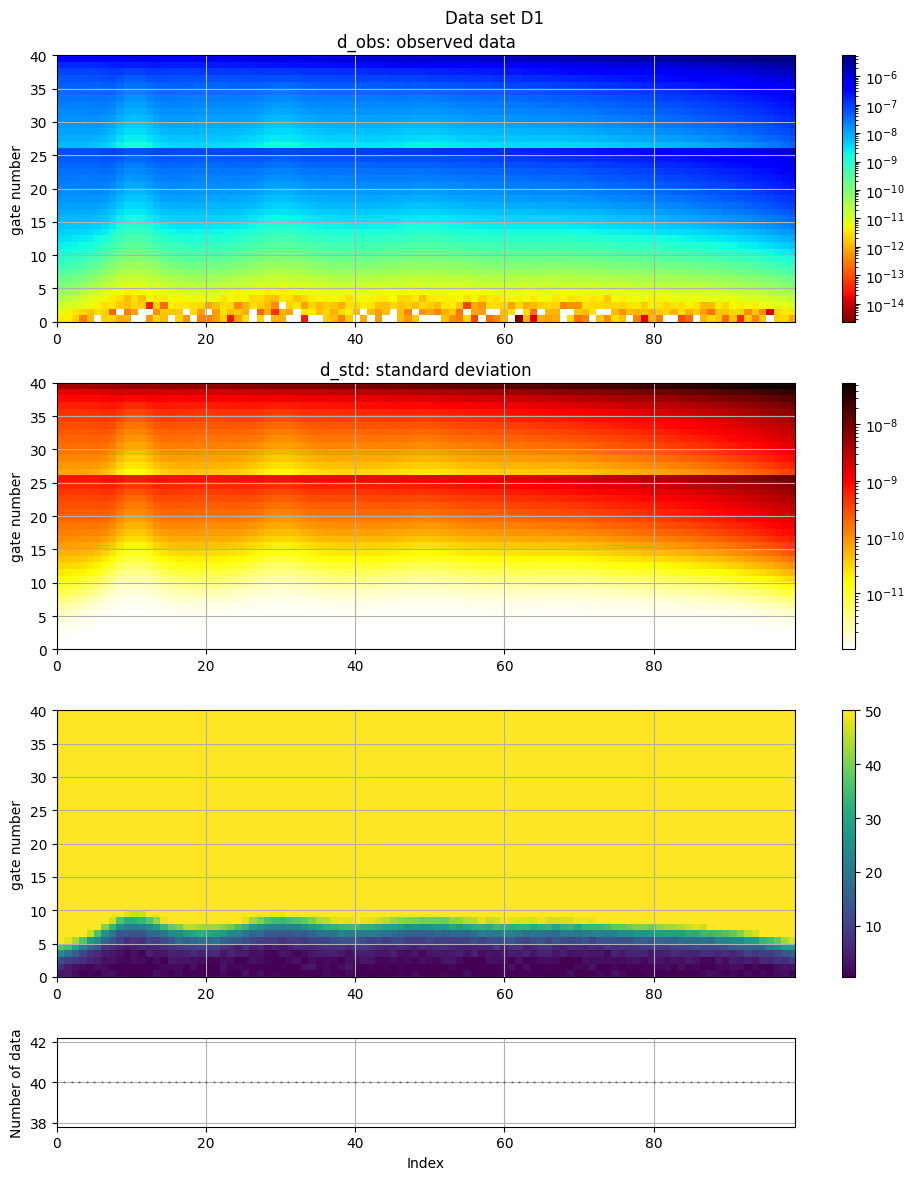

In [3]:
# Plot the model and data
plt.figure()
plt.subplot(2,1,1)
xx_ref, zz_ref = np.meshgrid(x_ref, z_ref)
plt.pcolor(xx_ref,zz_ref,M_ref.T)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()
plt.title('Reference model')
plt.subplot(2,1,2)
plt.semilogy(x_ref,D_ref);
plt.title('Reference data')

ig.plot_data(f_data_h5)

## Create prior model and data

prior_layered: 100%|█████████████████████████████████████████████████████████| 500000/500000 [00:08<00:00, 55578.01it/s]


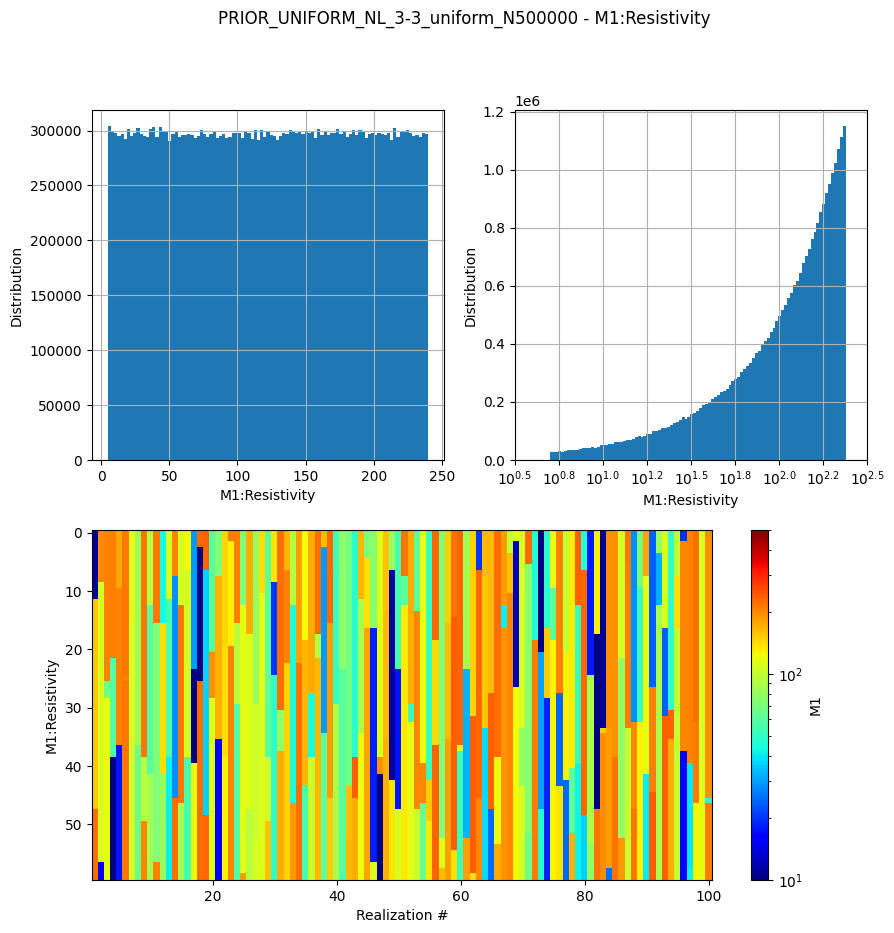

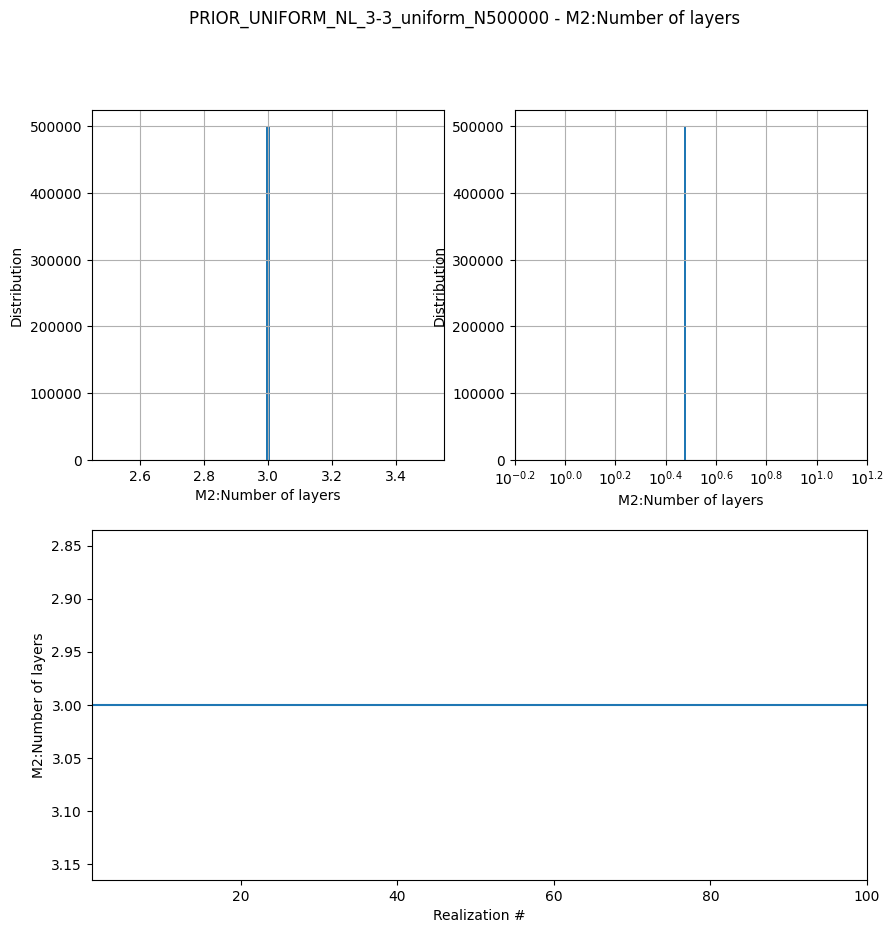

In [4]:
N=500000 # sample size 
f_prior_h5 = ig.prior_model_layered(N=N,
                                    lay_dist='uniform', z_max = z_max, 
                                    NLAY_min=3, NLAY_max=3, 
                                    RHO_dist='uniform', RHO_min=0.5*min(rho), RHO_max=2*max(rho))

ig.plot_prior_stats(f_prior_h5)

prior_data_gaaem: Using 64 parallel threads.


gatdaem1d: 100%|████████████████████████████████████████████████████████████████████| 7812/7812 [08:29<00:00, 15.32it/s]

gatdaem1d: 100%|████████████████████████████████████████████████████████████████████| 7813/7813 [09:12<00:00, 14.13it/s]


Time elapsed: 553.7 s, for 500000 soundings. 1.107 ms/sounding. 903.0it/s


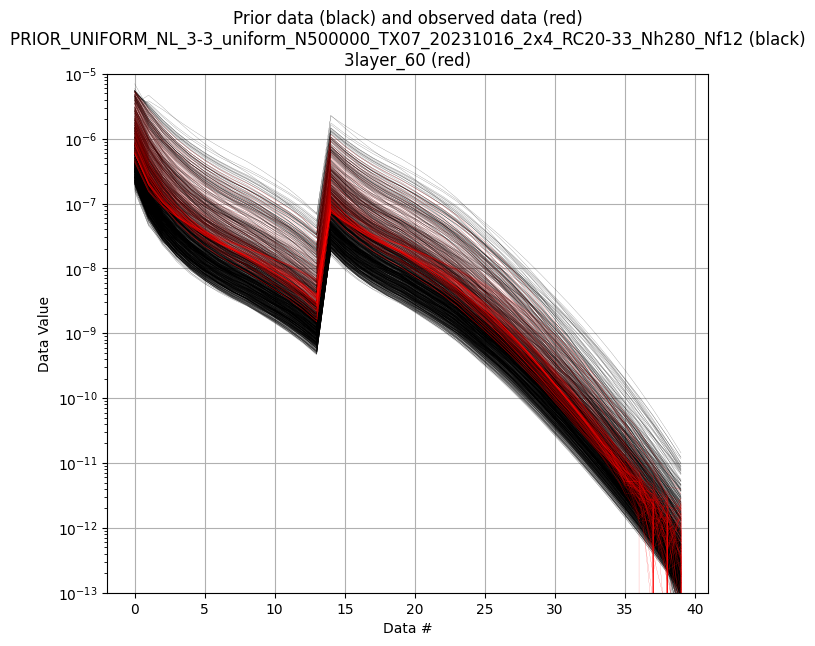

In [5]:
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex)

ig.plot_data_prior(f_prior_data_h5,f_data_h5,nr=1000,alpha=1, ylim=[1e-13,1e-5], hardcopy=hardcopy) 

## Perform inversion

In [6]:
f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, parallel=parallel, Ncpu=8)

Number of data points: 100 (available), 100 (used). Nchunks=8, Ncpu=8


rejection: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.21it/s]


T_av=46.4, Time=  8.9s/100 soundings ,89.5ms/sounding, 11.2it/s


poststat: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8785.72it/s]


Plot profile for all model parameters


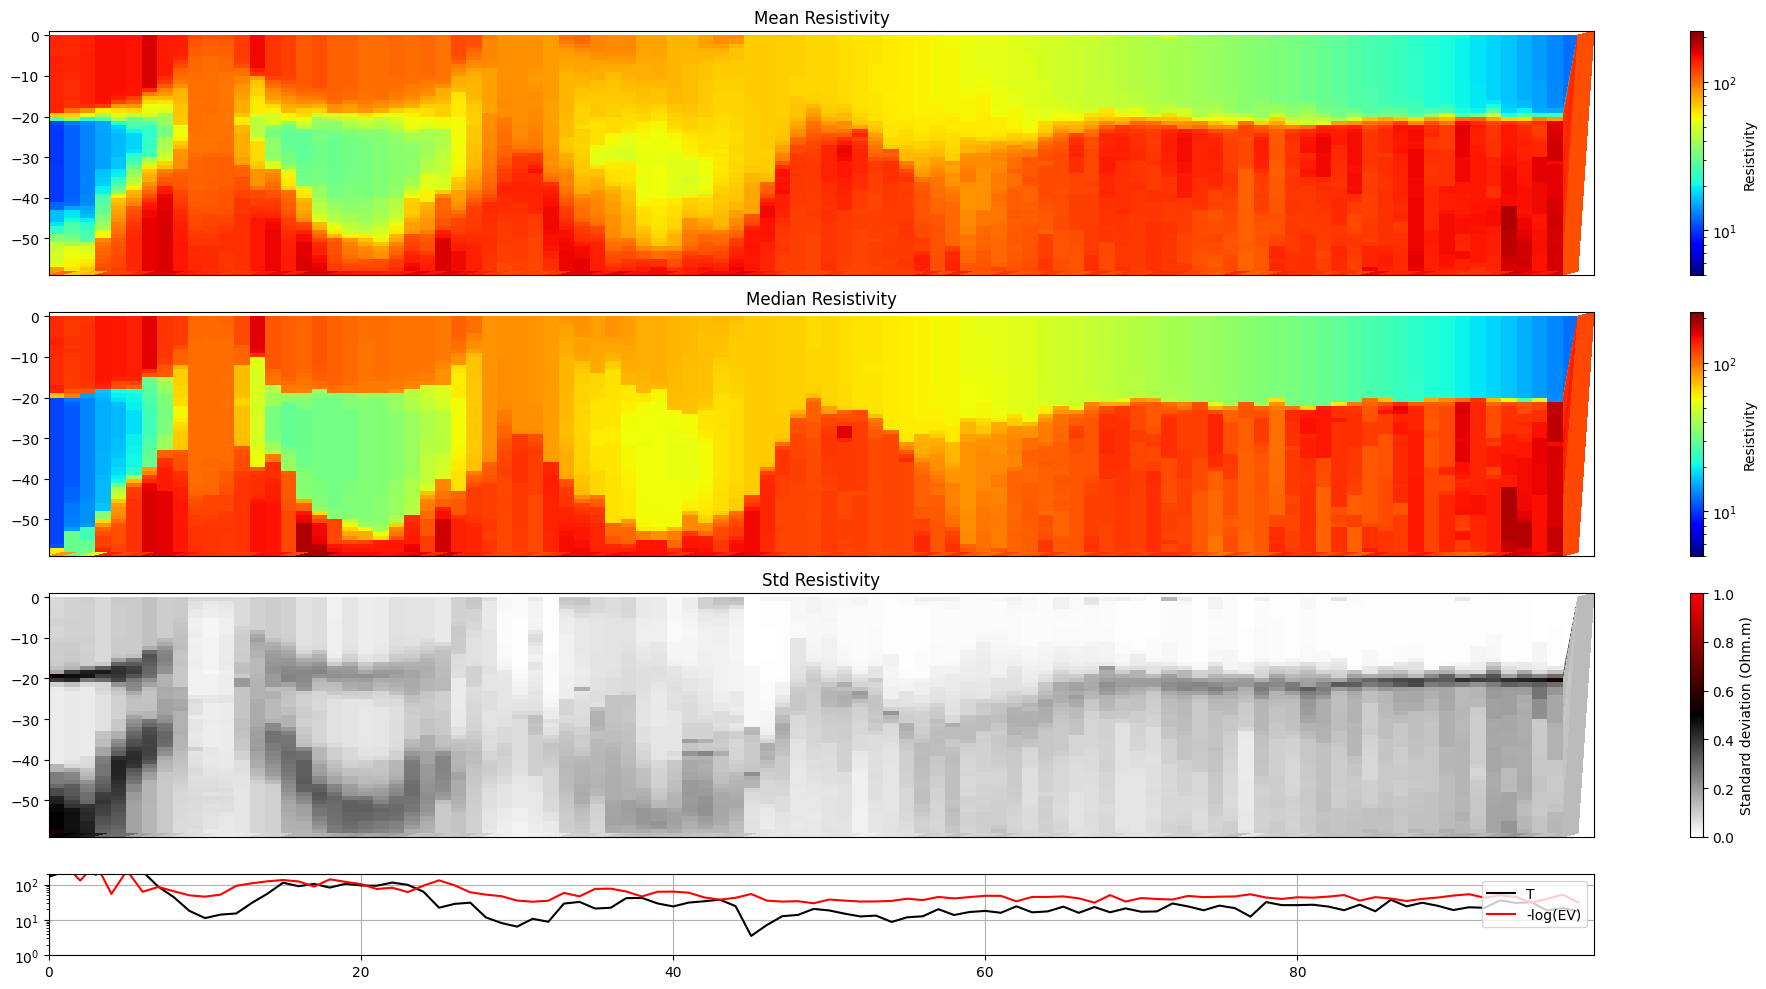

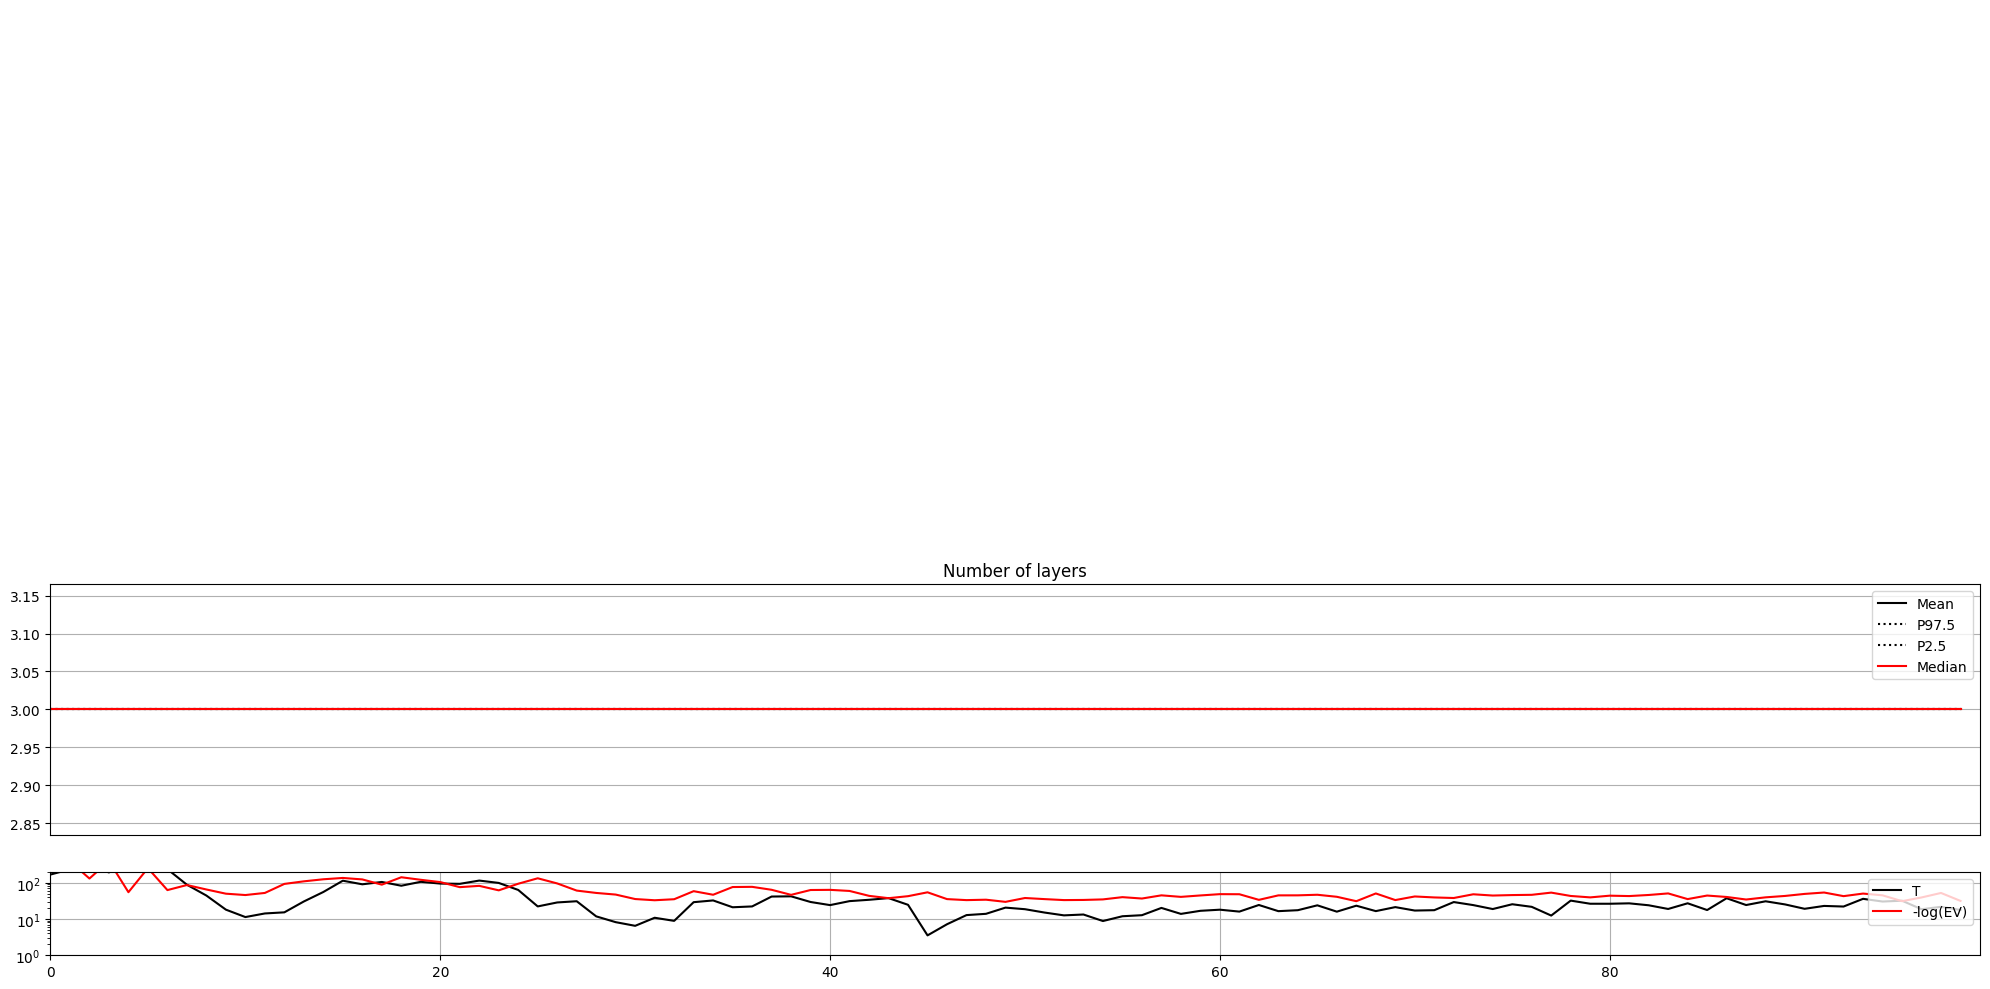

In [7]:
ig.plot_profile(f_post_h5, i1=0, i2=1000, hardcopy=hardcopy,  clim = [5, 220], im=0)

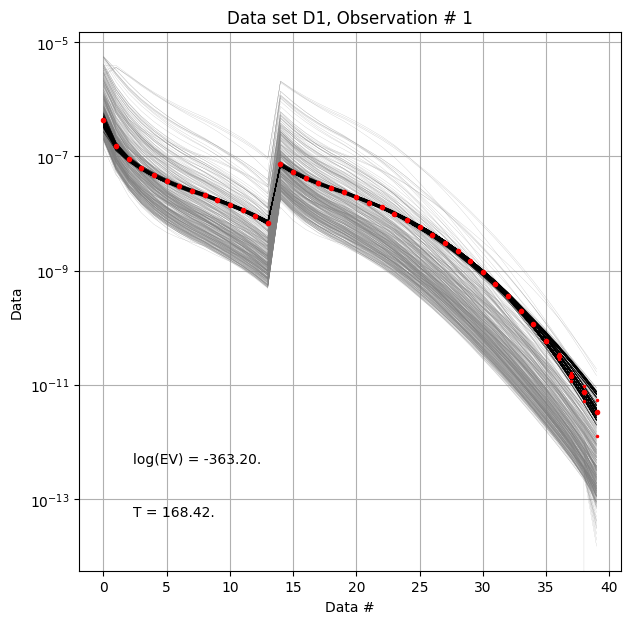

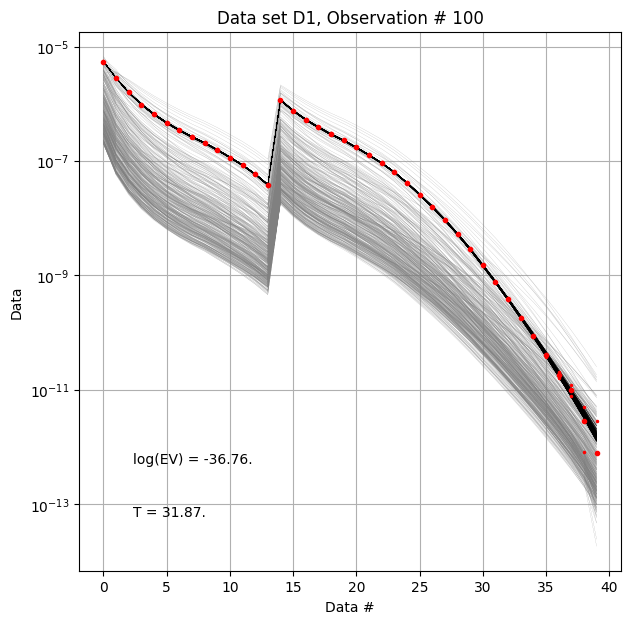

In [8]:
ig.plot_data_prior_post(f_post_h5, i_plot=0, hardcopy=hardcopy)
ig.plot_data_prior_post(f_post_h5, i_plot=len(x_ref)-1, hardcopy=hardcopy)

## Compare reference model to posterior median

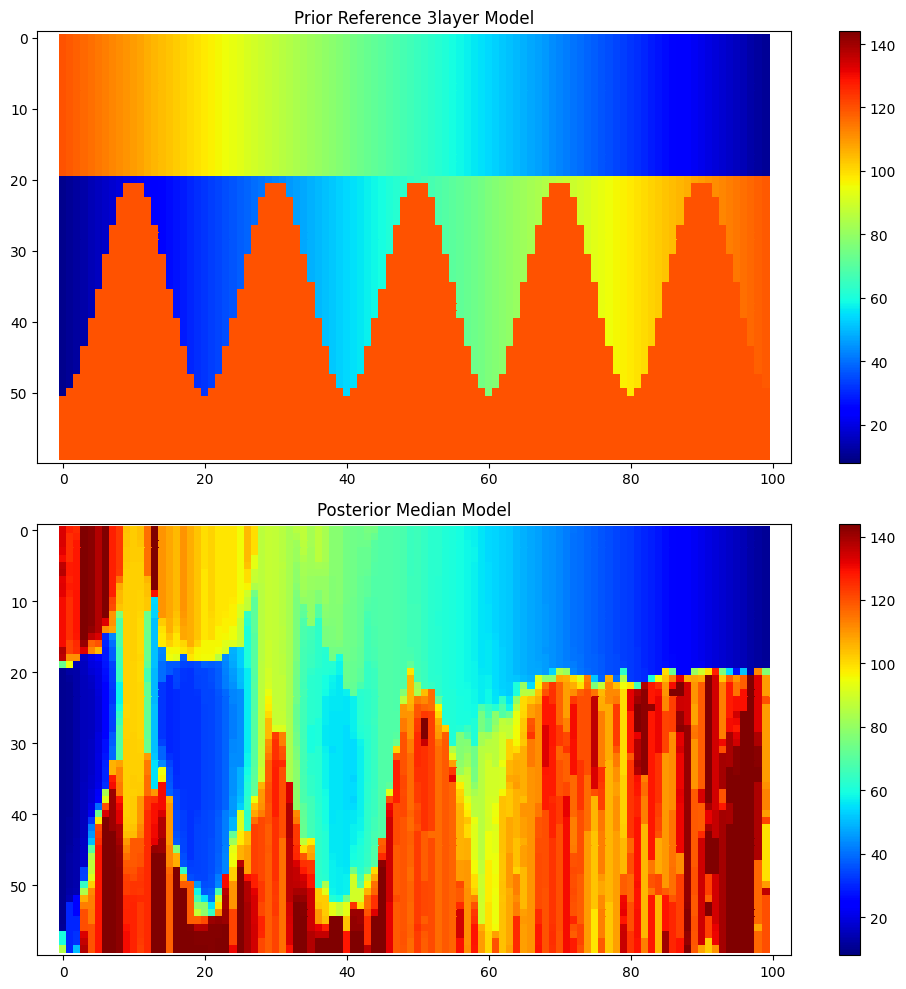

In [9]:
# Read 'M1/Median' from f_post_h5
with h5py.File(f_post_h5, 'r') as f_post:
    M_median = f_post['/M1/Median'][:]

with h5py.File(f_prior_h5,'r') as f_prior:
    # REad 'x' feature from f_prior
    z =  f_prior['/M1'].attrs['x']

xx, zz = np.meshgrid(x_ref, z)

# Make a figure with two subplots, each with plt.pcolor(xx,zz,M_median.T) and, plt.pcolor(xx_ref,zz_ref,M_ref.T), and use the same colorbar and x.axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

clim = [0.8*min(rho), 1.2*max(rho)]
# Second subplot
c1 = ax1.pcolor(xx_ref, zz_ref, M_ref.T, clim=clim, cmap='jet')
ax1.invert_yaxis()
ax1.axis('equal')
fig.colorbar(c1, ax=ax1)
ax1.set_title('Prior Reference %s Model' % case)

# First subplot
c2 = ax2.pcolor(xx, zz, M_median.T, clim=clim, cmap='jet')
ax2.invert_yaxis()
ax2.axis('equal')
fig.colorbar(c2, ax=ax2)
ax2.set_title('Posterior Median Model')

plt.tight_layout()
plt.savefig('Synthetic%s' % (case.upper()))
plt.show()